# Data Science Project - Zameen.com

## Real Estate Properties Analysis

In this project, we analyze a dataset of real estate properties to uncover insights, perform exploratory data analysis (EDA), visualize key aspects, and build machine learning models to predict property prices. The dataset contains various attributes such as price, type, location, number of bedrooms and bathrooms, area, and more.


### Imports

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# set visualization styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline

C:\Users\GNG\AppData\Local\Temp\ipykernel_14032\121722488.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading the dataset

In [2]:
# Load the dataset
df = pd.read_csv('properties.csv')

# Display initial info
print("Initial Dataset Info:")
df.info()

df.columns
df.head(8)

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home_id           10789 non-null  int64  
 1   price             10789 non-null  object 
 2   type              10789 non-null  object 
 3   location          10789 non-null  object 
 4   location_precise  10789 non-null  object 
 5   baths             10789 non-null  object 
 6   area              10789 non-null  object 
 7   purpose           10789 non-null  object 
 8   beds              10789 non-null  object 
 9   creation_date     10789 non-null  object 
 10  latitude          10789 non-null  float64
 11  longitude         10789 non-null  float64
 12  description       10789 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 1.1+ MB


,home_id,price,type,location,location_precise,baths,area,purpose,beds,creation_date,latitude,longitude,description
0,0,25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 6 - Block K, DHA Phase 6, DHA Defenc...",6 Baths,1 Kanal,For Sale,6 Beds,22 hours ago,31.468862,74.463358,SYED BROTHERS OFFERS:100% Original Pictures Ar...
1,1,11.25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6 Baths,2 Kanal,For Sale,5 Beds,1 hour ago,31.484893,74.472342,Khalifa Real Estate & Builders (R) Offers20-Ma...
2,2,10.95 Crore,House,"EME Society, Lahore, Punjab","EME Society - Block C, EME Society, Lahore, Pu...",6 Baths,1 Kanal,For Sale,5 Beds,7 hours ago,31.427857,74.213576,Near the parkNear the MasjidNear the commercia...
3,3,6.87 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 5, DHA Defence, Lahore, Punjab",7 Baths,1 Kanal,For Sale,5 Beds,1 hour ago,31.462493,74.409342,AA REAL ESTATE Offer Profitable1 Kanal Modern ...
4,4,7.45 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6 Baths,1 Kanal,For Sale,5 Beds,23 hours ago,31.484893,74.472342,About The Property:- 05 Master Size Bed Rooms ...
5,5,6.5 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 1 - Block N, DHA Phase 1, DHA Defenc...",6 Baths,1 Kanal,For Sale,5 Beds,1 hour ago,31.487345,74.395380,Zalmi Estate Offers:1 Kanal Well-Maintained Ho...
6,6,1.6 Crore,House,"Central Park Housing Scheme, Lahore, Punjab","Central Park - Block A1, Central Park Housing ...",4 Baths,5 Marla,For Sale,3 Beds,11 hours ago,31.326108,74.363547,5 Marla House for saleThis House worth Rs. 160...
7,7,6.5 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",5 Baths,1 Kanal,For Sale,5 Beds,8 hours ago,31.484893,74.472342,1 Kanal Most Beautiful Design Bungalow For Sal...


In [3]:
unique_creation_dates = df['creation_date'].nunique()

# Display the result
print(f"Unique creation dates: {unique_creation_dates}")

Unique creation dates: 57


## Cleaning the dataset

In [4]:
# function to extract numerical values from strings
def extract_number(text):
    try:
        return int(re.search(r'(\d+)', text).group(1))
    except:
        return np.nan

# function to convert Kanal and Marla into a unified unit (marlas)
def convert_area_to_marlas(area):
    try:
        if 'Kanal' in area:
            return float(area.split()[0]) * 20
        elif 'Marla' in area:
            return float(area.split()[0])
        else:
            return np.nan
    except Exception as e:
        print(f"Error in 'area' column for value '{area}': {e}")
        return np.nan
    

# converting 'Lakhs' to crores and cleaning the price column
def convert_price_to_crores(price):
    try:
        # remove 'PKR' if present
        price = price.replace('PKR', '').strip()
        
        if 'Lakh' in price:
            return float(price.split()[0]) / 100  # converting Lakhs to Crores
        elif 'Crore' in price:
            return float(price.split()[0])  # crores remain as is
        else:
            return np.nan
    except Exception as e:
        print(f"Error in 'price' column for value '{price}': {e}")
        return np.nan

# function to convert the time to days
def convert_creation_date_to_days(date):
    try:
        if 'minute' in date or 'hour' in date:
            # treat everything under 24 hours as 1 day
            return 1
        elif 'day' in date:
            return int(date.split()[0])
        else:
            return np.nan
    except Exception as e:
        print(f"Error in 'creation_date' column for value '{date}': {e}")
        return np.nan

In [5]:
# removing home_id column as it's redundant
df.drop('home_id', axis=1, inplace=True)

# cleaning the 'beds' and 'baths' columns -- remove 'Beds' and 'Baths' from the strings and convert to integer
df['beds'] = df['beds'].apply(extract_number)
df['baths'] = df['baths'].apply(extract_number)

# converting 'area' to marlas -- creating a new column 'area_in_marlas'
df['area_in_marlas'] = df['area'].apply(convert_area_to_marlas)

# cleaning the 'price' column
df['price_in_crores'] = df['price'].apply(convert_price_to_crores)

# convert 'creation_date' to days
df['creation_days_ago'] = df['creation_date'].apply(convert_creation_date_to_days)

# checking for null values and handling them
# print("\nNull Values Before Cleaning:")
# print(df.isnull().sum())
print(df.shape)

# For temporal analysis, we will use only the rows where 'creation_days_ago' is not NaN
df_temporal = df[df['creation_days_ago'].notna()]

# need to drop rows with missing baths and beds values
df = df.dropna(subset=['beds', 'baths'])

# print("count: %d\n", df.isnull().sum())
df.shape

# # drop rows with missing critical data (price, area, beds, baths, creation date)
# df_cleaned = df.dropna(subset=['price_in_crores', 'area_in_marlas', 'beds', 'baths', 'creation_days_ago'])

(10789, 15)


(10411, 15)

In [6]:
# Remove the 'for' prefix from the purpose column
df['purpose'] = df['purpose'].str.replace('for ', '', case=False)

# Display the unique values in the purpose column to confirm the changes
print(df['purpose'].unique())


['Sale']


### Displaying updated dataframe

In [7]:
df_cleaned = df
# Final dataset information
print("\nCleaned Dataset Info:")
df_cleaned.info()

# Displaying a few rows of the cleaned dataset
print("\nCleaned Data Sample:")
print(df_cleaned.head())

# Saving the cleaned dataset for further EDA
df_cleaned.to_csv('cleaned_properties.csv', index=False)


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10411 entries, 0 to 10788
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              10411 non-null  object 
 1   type               10411 non-null  object 
 2   location           10411 non-null  object 
 3   location_precise   10411 non-null  object 
 4   baths              10411 non-null  float64
 5   area               10411 non-null  object 
 6   purpose            10411 non-null  object 
 7   beds               10411 non-null  float64
 8   creation_date      10411 non-null  object 
 9   latitude           10411 non-null  float64
 10  longitude          10411 non-null  float64
 11  description        10411 non-null  object 
 12  area_in_marlas     10411 non-null  float64
 13  price_in_crores    10409 non-null  float64
 14  creation_days_ago  6279 non-null   float64
dtypes: float64(7), object(8)
memory usage: 1.3+ MB

Clea

## Exploratory Data Analysis

In [12]:
# conducting basic EDA

# basic summary statistics
print("\nSummary Statistics:")
print(df_cleaned.describe())

# distribution of price (crores)
# print("\nPrice Distribution:")
# print(df_cleaned['price_in_crores'].describe())

# # distribution of area (marlas)
# print("\nArea Distribution:")
# print(df_cleaned['area_in_marlas'].describe())

# # distribution of beds and baths
# print("\nBeds and Baths Distribution:")
# print(df_cleaned[['beds', 'baths']].value_counts())

# # correlation analysis (price vs area, beds vs price, etc.)
# print("\nCorrelation Matrix:")
# print(df_cleaned[['price_in_crores', 'area_in_marlas', 'beds', 'baths']].corr())


Summary Statistics:
              baths          beds      latitude     longitude  area_in_marlas  \
count  10411.000000  10411.000000  10411.000000  10411.000000    10411.000000   
mean       4.833157      4.237729     31.467380     74.325718       15.509375   
std        1.363839      1.359162      0.843267      0.846896       35.081793   
min        1.000000      1.000000     31.241031     31.363093        0.000000   
25%        4.000000      3.000000     31.408374     74.247222        5.000000   
50%        5.000000      4.000000     31.461285     74.373808       10.000000   
75%        6.000000      5.000000     31.483429     74.438589       20.000000   
max        8.000000     11.000000     74.401394     74.573340     1280.000000   

       price_in_crores  creation_days_ago  
count     10409.000000        6279.000000  
mean          5.391220           2.405797  
std           6.371981           1.603995  
min           0.147500           1.000000  
25%           2.000000       

### Distribution of Variables

In [13]:
df_cleaned.head(20)

,price,type,location,location_precise,baths,area,purpose,beds,creation_date,latitude,longitude,description,area_in_marlas,price_in_crores,creation_days_ago
0,25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 6 - Block K, DHA Phase 6, DHA Defenc...",6.0,1 Kanal,Sale,6.0,22 hours ago,31.468862,74.463358,SYED BROTHERS OFFERS:100% Original Pictures Ar...,20.0,25.00,1.0
1,11.25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6.0,2 Kanal,Sale,5.0,1 hour ago,31.484893,74.472342,Khalifa Real Estate & Builders (R) Offers20-Ma...,40.0,11.25,1.0
2,10.95 Crore,House,"EME Society, Lahore, Punjab","EME Society - Block C, EME Society, Lahore, Pu...",6.0,1 Kanal,Sale,5.0,7 hours ago,31.427857,74.213576,Near the parkNear the MasjidNear the commercia...,20.0,10.95,1.0
3,6.87 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 5, DHA Defence, Lahore, Punjab",7.0,1 Kanal,Sale,5.0,1 hour ago,31.462493,74.409342,AA REAL ESTATE Offer Profitable1 Kanal Modern ...,20.0,6.87,1.0
4,7.45 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6.0,1 Kanal,Sale,5.0,23 hours ago,31.484893,74.472342,About The Property:- 05 Master Size Bed Rooms ...,20.0,7.45,1.0
5,6.5 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 1 - Block N, DHA Phase 1, DHA Defenc...",6.0,1 Kanal,Sale,5.0,1 hour ago,31.487345,74.395380,Zalmi Estate Offers:1 Kanal Well-Maintained Ho...,20.0,6.50,1.0
6,1.6 Crore,House,"Central Park Housing Scheme, Lahore, Punjab","Central Park - Block A1, Central Park Housing ...",4.0,5 Marla,Sale,3.0,11 hours ago,31.326108,74.363547,5 Marla House for saleThis House worth Rs. 160...,5.0,1.60,1.0
7,6.5 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",5.0,1 Kanal,Sale,5.0,8 hours ago,31.484893,74.472342,1 Kanal Most Beautiful Design Bungalow For Sal...,20.0,6.50,1.0
8,1.27 Crore,House,"Johar Town, Lahore, Punjab","Johar Town, Lahore, Punjab",3.0,3 Marla,Sale,3.0,37 minutes ago,31.462347,74.293642,MIAN REAL ESTATE AND ADVISOR OFFERS YOU3 MARLA...,3.0,1.27,1.0
9,3.75 Crore,House,"Township, Lahore, Punjab","Township, Lahore, Punjab",6.0,10 Marla,Sale,8.0,37 minutes ago,31.451804,74.310436,MIAN REAL ESTATE AND ADVISOR Offers Best Inves...,10.0,3.75,1.0


### Dropping entries that are exact duplicates (Except the last column (description) as it can be same for multiple entries)

In [14]:
# Drop exact duplicates and keep only the first occurrence
df_cleaned_no_duplicates = df_cleaned.drop_duplicates()

# Remove the last comma from 'location_precise' if it exists
df_cleaned['location_precise'] = df_cleaned['location_precise'].str.rstrip(',')


# Display the DataFrame after removing duplicates
print("Data after removing exact duplicates:")
print(df_cleaned_no_duplicates)



Data after removing exact duplicates:
             price   type                              location  \
0         25 Crore  House           DHA Defence, Lahore, Punjab   
1      11.25 Crore  House           DHA Defence, Lahore, Punjab   
2      10.95 Crore  House           EME Society, Lahore, Punjab   
3       6.87 Crore  House           DHA Defence, Lahore, Punjab   
4       7.45 Crore  House           DHA Defence, Lahore, Punjab   
...            ...    ...                                   ...   
10779    3.5 Crore  House  Beacon House Society, Lahore, Punjab   
10781      75 Lakh  House               Tajpura, Lahore, Punjab   
10782      85 Lakh  House               Tajpura, Lahore, Punjab   
10783      85 Lakh  House               Tajpura, Lahore, Punjab   
10788      45 Lakh  House               Tajpura, Lahore, Punjab   

                                        location_precise  baths       area  \
0      DHA Phase 6 - Block K, DHA Phase 6, DHA Defenc...    6.0    1 Kanal   
1

# Cleaned DataFrame

In [15]:

df_cleaned.head()


,price,type,location,location_precise,baths,area,purpose,beds,creation_date,latitude,longitude,description,area_in_marlas,price_in_crores,creation_days_ago
0,25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 6 - Block K, DHA Phase 6, DHA Defenc...",6.0,1 Kanal,Sale,6.0,22 hours ago,31.468862,74.463358,SYED BROTHERS OFFERS:100% Original Pictures Ar...,20.0,25.00,1.0
1,11.25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6.0,2 Kanal,Sale,5.0,1 hour ago,31.484893,74.472342,Khalifa Real Estate & Builders (R) Offers20-Ma...,40.0,11.25,1.0
2,10.95 Crore,House,"EME Society, Lahore, Punjab","EME Society - Block C, EME Society, Lahore, Pu...",6.0,1 Kanal,Sale,5.0,7 hours ago,31.427857,74.213576,Near the parkNear the MasjidNear the commercia...,20.0,10.95,1.0
3,6.87 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 5, DHA Defence, Lahore, Punjab",7.0,1 Kanal,Sale,5.0,1 hour ago,31.462493,74.409342,AA REAL ESTATE Offer Profitable1 Kanal Modern ...,20.0,6.87,1.0
4,7.45 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6.0,1 Kanal,Sale,5.0,23 hours ago,31.484893,74.472342,About The Property:- 05 Master Size Bed Rooms ...,20.0,7.45,1.0


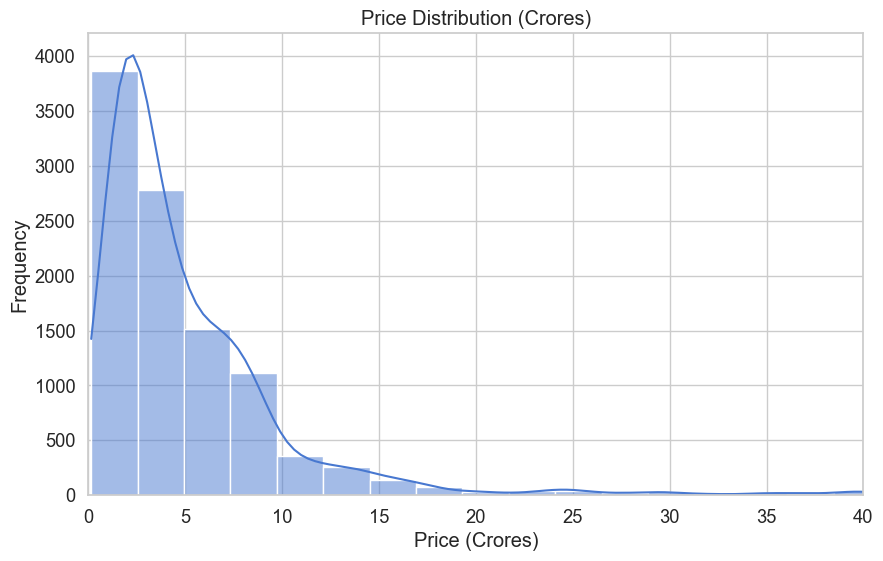

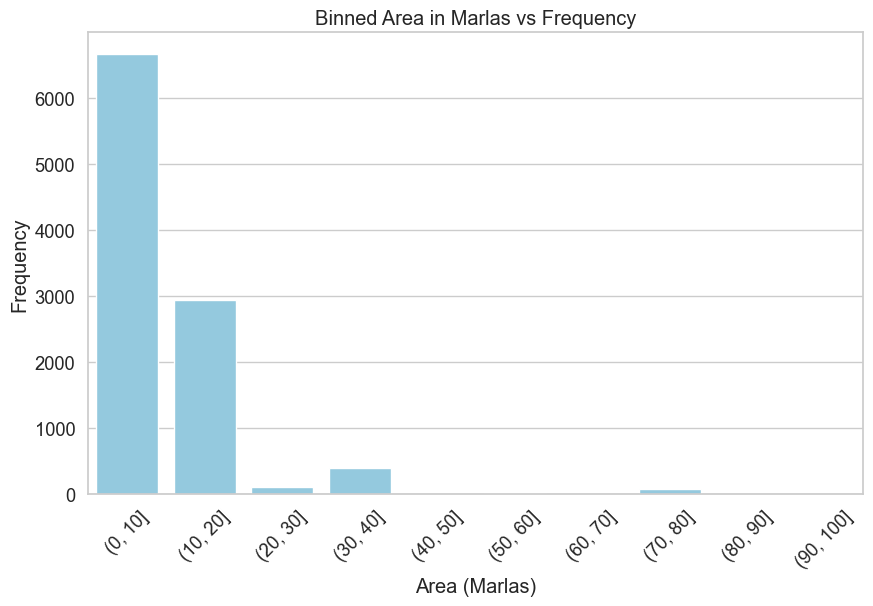

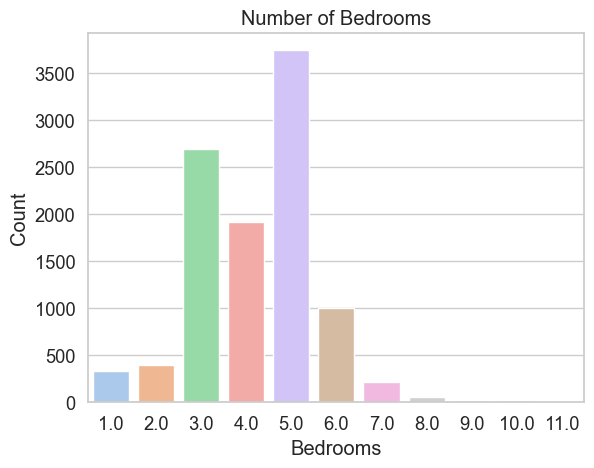

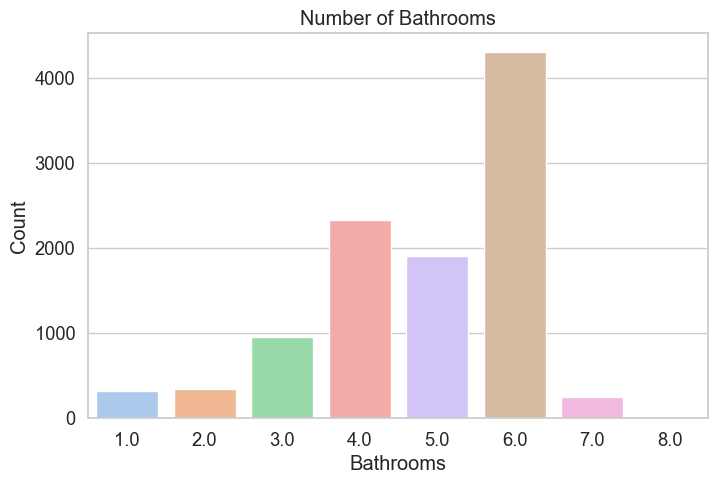

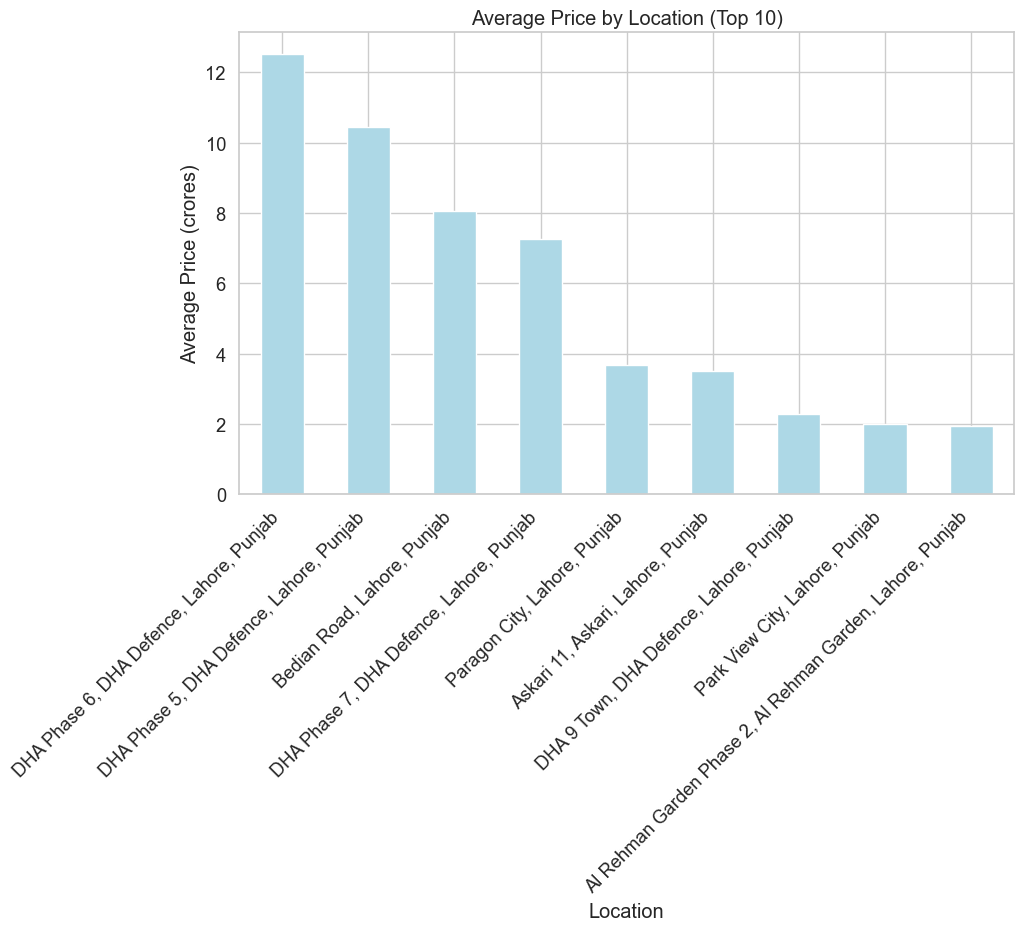

In [19]:
# Price Distribution with Custom X-Axis Range
plt.figure(figsize=(10,6))
sns.histplot(df_cleaned['price_in_crores'], bins=30, kde=True)
plt.title('Price Distribution (Crores)')
plt.xlabel('Price (Crores)')
plt.ylabel('Frequency')
plt.xlim(0, 40)  # Adjust the range as needed
plt.show()


df_filtered = df_cleaned[df_cleaned['area_in_marlas'] > 0]
df_filtered['area_bin'] = pd.cut(df_filtered['area_in_marlas'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
area_counts = df_filtered['area_bin'].value_counts().sort_index().reset_index()
area_counts.columns = ['area_bin', 'frequency']

plt.figure(figsize=(10, 6))
sns.barplot(x='area_bin', y='frequency', data=area_counts, color='skyblue')
plt.title('Binned Area in Marlas vs Frequency')
plt.xlabel('Area (Marlas)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Beds Distribution
sns.countplot(x='beds', data=df_cleaned, palette='pastel')  # Change color here
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()

# Baths Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='baths', data=df_cleaned, palette='pastel')
plt.title('Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')
plt.show()

# Average price by location
filtered_locations = df_cleaned.groupby('location_precise').filter(lambda x: len(x) >= 100)
avg_price_by_location = filtered_locations.groupby('location_precise')['price_in_crores'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
avg_price_by_location.plot(kind='bar', color='lightblue')
plt.title("Average Price by Location (Top 10)")
plt.xlabel("Location")
plt.ylabel("Average Price (crores)")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()

### Correlation Analysis

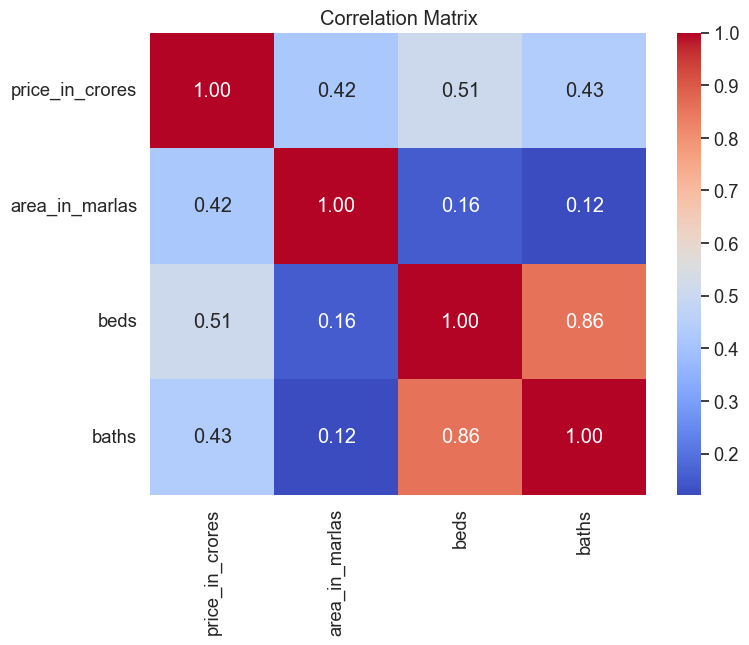

In [20]:
# correlation matrix -- heatmap
plt.figure(figsize=(8,6))
corr_matrix = df_cleaned[['price_in_crores', 'area_in_marlas', 'beds', 'baths']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Scatter and Box Plots

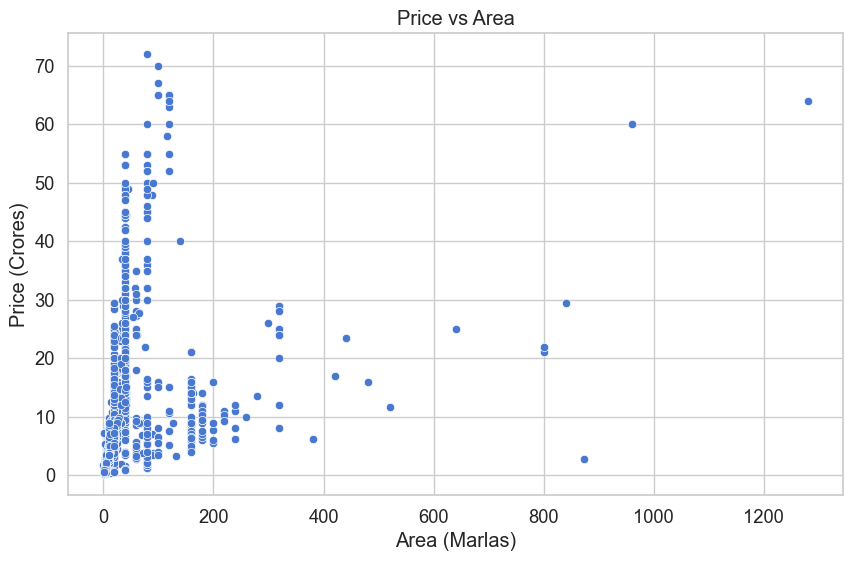

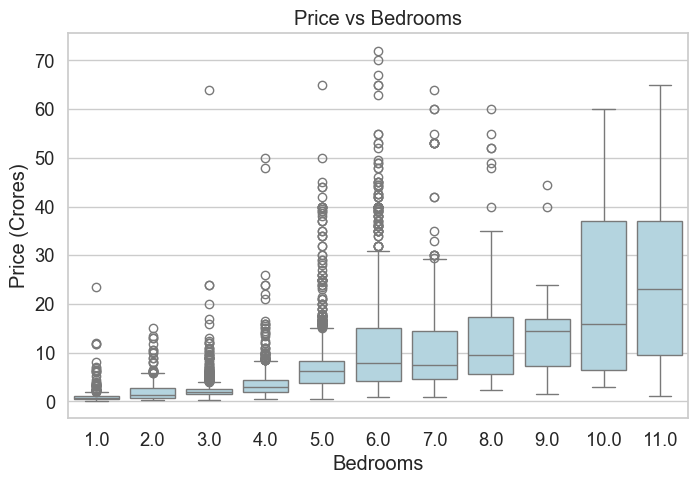

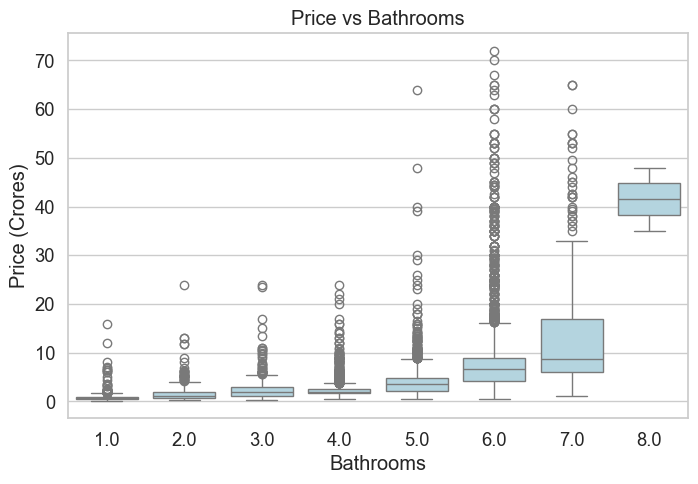

In [21]:
# Price vs Area
plt.figure(figsize=(10,6))
sns.scatterplot(x='area_in_marlas', y='price_in_crores', data=df_cleaned)
plt.title('Price vs Area')
plt.xlabel('Area (Marlas)')
plt.ylabel('Price (Crores)')
plt.show()

# Price vs Bedrooms
plt.figure(figsize=(8,5))
sns.boxplot(x='beds', y='price_in_crores', data=df_cleaned, color='lightblue')
plt.title('Price vs Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price (Crores)')
plt.show()

# Price vs Bathrooms
plt.figure(figsize=(8,5))
sns.boxplot(x='baths', y='price_in_crores', data=df_cleaned, color='lightblue')
plt.title('Price vs Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Price (Crores)')
plt.show()

#  Creating a heatmap centered around Lahore, representing property prices in crores.

In [36]:
import folium
from folium.plugins import HeatMap
from IPython.display import display


df_cleaned = df_cleaned.dropna(subset=['latitude', 'longitude', 'price_in_crores'])
df_cleaned['price_in_crores'] = pd.to_numeric(df_cleaned['price_in_crores'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['price_in_crores'])

heat_data = [
    [row['latitude'], row['longitude'], row['price_in_crores']]
    for index, row in df_cleaned.iterrows()
]
m = folium.Map(location=[31.5204, 74.3587], zoom_start=10)
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)
from IPython.display import display
display(m)


In [37]:
avg_prices = df_cleaned.groupby(['latitude', 'longitude'])['price_in_crores'].mean().reset_index()

heat_data = [
    [row['latitude'], row['longitude'], row['price_in_crores']]
    for index, row in avg_prices.iterrows()
]
m = folium.Map(location=[31.5204, 74.3587], zoom_start=10)
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)
from IPython.display import display
display(m)